# Outlier Detection of 4 Digit MWC 4 Players using Tournament Scores using Box-Cox Transformation and Average Percentile Model

## Introduction

This notebook is the explanation and experimentation on an Alternative of Local Outlier Factor with a simpler model, which is an Average Percentile Model.

## Logit Transformation

**Logit Transformation** is a terminology to transform the score which are in range $[0, 1000000]$ into $(-\infty, \infty)$ using the formula

$$
\text{logit}(x) = \log(\frac{x}{1 - x})
$$

Where
$$
x = \frac{\text{score}}{1000000}
$$

This will also theoretically widen the gap between small difference of scores when the scores are higher. For example the difference between $\text{logit}(0.99) - \text{logit}(0.985)$ is less than $\text{logit}(0.995) - \text{logit}(0.99)$. Which matches the environment in the osu!mania tournament scene since the chance that the score gaps are low in earlier game is higher than the late game.

## Box-Cox Transformation

**Box-Cox Transformation** can be written as

$$
\text{boxcox}(x) = \begin{cases}
\frac{x^\lambda - 1}{\lambda} & \lambda \neq 0\\
\log(x) & \lambda = 0
\end{cases}
$$

Theoretically, the following transformation will make the data more Normally Distributed. We can find the $\lambda$ using **Maximum Likelihood** which will try to find the $\lambda$ that maximize how "Normally Distributed" the data is.

More information and experimentations can be found in [boxcox.ipynb](https://github.com/HowToProgramming/4dm4analysis/blob/main/boxcox.ipynb)

## Parametric Average Percentile Model

**Parametric Average Percentile Model** is based on the idea of how to measure the proportion of the population that a given player has surprassed. The data in this case is multi-dimensional data, that means there are multiple maps in the calculation process of this model. First we standardize the data of each map, then we calculate the **Cumulative Distribution Function** of **Normal Distribution** or any given parametric distribution, we will call that a percentile. After that we average the percentile and get the final result of a given player.

### Adjustments

#### Applying Box-Cox Transformation

As mentioned in the previous section about Box-Cox Transformation, we transform the Logit-Transformed data using Box-Cox transformation in order to use them in the **Parametric Average Percentile Model**. This will maximize the efficiency of the model, however there is a case where $\lambda < 0$ which we should aware of because the higher the score, the lower the transformed value is, we then use another adjustment

$$
\text{sign}(\lambda) = \begin{cases}
1 & \lambda \geq 0\\
-1 & \text{otherwise}
\end{cases}
$$

We multiply them with our standardized value and then use that value to calculate the **Cumulative Distribution Function** in order to catch that issue.

#### Applying Maps Played into the consideration

After we got the output from our Model, we then find another factor which the model didn't catch which is the "Maps Played". The important behaviour of outperformed players is the fact that they usually are main players of most of the maps. So we try to include this feature by multiplying the outlier value that we got from model with the log of maps played. Which is the following formula:

$$
\text{Adjusted Outlier Score} = \text{Outlier Value from Avg. Percentile} \cdot \log(\# \text{Maps Played} + 1)
$$

We then use this value to detect the outlier or outperformed players.

## In Layman Terms

"At the first instinct, the way to classify the outperforming players is to find the players who are outperforming." <p align="right">- HowToPlayLN, 2022, while thinking how to write this section</p>

But the more important question is, how do we define outperforming ? Given a player, an easy idea is to calculate how many players a given player has surpressed in a certain map. To be precise, we try to compare the player with the entire population of players who are eligible to participate in a tournament. In order to compare (approximate) directly, we need to use the statistical magic called "Normal Distribution".<p hidden=true>which there is no turning back if we commit it (sry overused joke)</p>

But we cannot use the Normal Distribution directly, from the raw score, we need to use some transformation to extract some features and normalize them. First, we use the "logit transformation" to seperate the stacked performances of players in the tournament, for example, we can see more distinction between 990k and 995k score than 985k and 990k, which matches the environment of how osu!mania tournaments usually works. Next, we use the "Box-Cox Transformation" in order to make data suitable for the statistical magic.

We then input the transformed data into the statistical magic that allows us to approximate how much the player has surprassed the population. However, we do this for every single map in a tournament and use all sample players data to determine the approximated value. Then we average the values for all maps a player played in a tournament.

Finally, the last feature comes from the nature of the behaviour of outperforming players in a tournament, especially a country team tournament with the format of 3v3 and 6 players for each country. They usually are the first or second player of the maps. With this information, we can add the "maps played" feature into the consideration. We do this by taking a logarithm function to maps played to reduce the difference between players who plays in the late game and focus more on them. We then multiply that value to the previous feature, then we get the numbers that will determine whether the player is outperforming.

## Code Documentation

In [1]:
import os

os.chdir("..")

### Importing Necessary Modules

We will use `pandas` for data management, `matplotlib.pyplot` for data visualization and `numpy` to deal with math stuff.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

For Local Packages, we will use `Dataset` and `get_table_players` to transform dataset into the 

In [3]:
from utils import Dataset
from utils.outlierdetectionmodel import BoxCoxParametricAveragePercent
from utils.dftransformer import get_table_players

In [4]:
_4dm4_dataset = Dataset('datasets/4dm3.db')

In [5]:
_4dm4_data = _4dm4_dataset.select('scores', columns=['player_name', 'round', 'beatmap_type', 'beatmap_tag', 'score_logit'], where={
    'beatmap_type': ['LN', 'RC', 'HB'],
})

In [6]:
_4dm4_data.head()

,player_name,round,beatmap_type,beatmap_tag,score_logit
0,drag_,Q,RC,1,3.922366
1,JPBenedictGame,Q,RC,1,4.792686
2,iVALORUS,Q,RC,1,2.952871
3,BL5,Q,RC,1,5.119073
4,-Tebo-,Q,RC,1,5.221730


In [7]:
player_table = get_table_players(_4dm4_data)

In [8]:
player_table

,Q_RC_1,Q_RC_2,Q_LN_1,Q_HB_1,RO32_RC_1,RO32_RC_4,RO32_RC_5,RO32_LN_3,RO32_HB_1,RO16_RC_1,...,GF_RC_7,GF_LN_2,GF_LN_3,GF_LN_4,GF_HB_1,GF_HB_2,GF_HB_3,SF_RC_2,SF_HB_3,GF_RC_3
drag_,3.922366,2.913464,3.310021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
JPBenedictGame,4.792686,3.630805,3.143908,3.262931,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
iVALORUS,2.952871,2.364221,1.976354,2.624503,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BL5,5.119073,2.868556,3.635748,3.548144,3.984893,3.215893,4.803535,4.269779,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-Tebo-,5.221730,3.583254,3.915976,3.042808,5.207228,4.899665,5.370992,4.391723,5.008284,5.030982,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
oliverq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TheFunk,NaN,NaN,NaN,NaN,NaN,4.256847,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Herarudo,NaN,NaN,NaN,NaN,NaN,NaN,5.109978,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
[Antonio],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.711016,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
model = BoxCoxParametricAveragePercent()

model.fit(player_table.values)

In [10]:
df = pd.DataFrame(index=player_table.index)

df['outlier_values'] = model.predict(player_table.values)

In [11]:
df.sort_values(by='outlier_values', ascending=False).head(16)

,outlier_values
NotXbxx,0.938812
Paturages,0.808961
Micleak,0.802119
NifloX_,0.795386
Ricizus,0.779673
shokoha,0.754505
JayLye,0.739499
XN_The_XD,0.720398
Gray Hardrock,0.718346
Pluty,0.713545


In [12]:
df['n_maps_played'] = np.sum(pd.notna(player_table.values), axis=1)

In [13]:
df

,outlier_values,n_maps_played
drag_,0.210072,3
JPBenedictGame,0.369865,4
iVALORUS,0.043815,4
BL5,0.336032,8
-Tebo-,0.542988,17
...,...,...
oliverq,0.248482,7
TheFunk,0.365996,2
Herarudo,0.303336,2
[Antonio],0.076878,2


In [14]:
df['adjusted_ol_values'] = df['outlier_values'] * np.log(df['n_maps_played'] + 1)

In [15]:
df.sort_values(by='adjusted_ol_values', ascending=False).head(15)

,outlier_values,n_maps_played,adjusted_ol_values
shokoha,0.754505,50,2.966581
Micleak,0.802119,31,2.779934
Gray Hardrock,0.718346,45,2.750291
Lazereed,0.688086,41,2.571839
Ricizus,0.779673,26,2.569676
[LS]Byte,0.651652,44,2.480619
henryalexbr,0.638299,45,2.443816
JayLye,0.739499,26,2.437267
Keskidi,0.642740,43,2.432250
MisteurFR,0.691559,31,2.396761


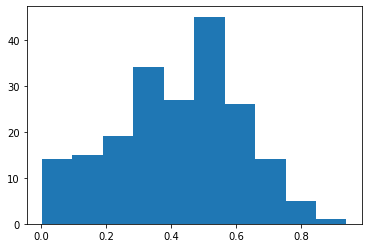

In [16]:
plt.hist(df['outlier_values'])
plt.show()

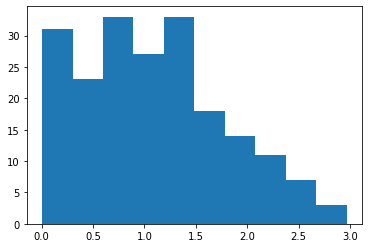

In [17]:
plt.hist(df['adjusted_ol_values'])
plt.show()